In [1]:
!pip install np_utils keras

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
import warnings
import librosa
import librosa.display
from google.colab import drive
import tensorflow as tf
from keras.layers import LSTM
from keras.utils import plot_model
import keras.backend as K
import tensorflow as tf

In [3]:
tf.keras.backend.clear_session()

In [4]:
if not sys.warnoptions:
  warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
parent_folder = '/content/drive/MyDrive/Colab Notebooks/Audio Classification/Deep Learning/Branched Convolutional Neural Networks/'

In [7]:
data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Audio Classification/Dataset/Final Path File/final_path.csv')
data_path['Index'] = data_path.index

In [8]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

In [9]:
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate=rate)

In [10]:
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

In [11]:
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [12]:
path = np.array(data_path['Path'])[1]
data, sample_rate = librosa.load(path)

In [13]:
def extract_features(data):
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr))
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  return result

In [14]:
def get_features(path):
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
  res1 = extract_features(data)
  result = np.array(res1)
  noise_data = noise(data)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2))
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch)
  result = np.vstack((result, res3))
  return result

In [15]:
X, Y = [], []
if 'features.csv' not in set(os.listdir(parent_folder)):
  for index, path, emotion in zip(data_path['Index'], data_path['Path'], data_path['Emotion']):
    feature = get_features(path)
    if (index % 100 == 0):
      print("Import Data: RUNNING ... {} files".format(index))
    for ele in feature:
      X.append(ele)
      Y.append(emotion)
  print(len(X))
  print(len(Y))
  print(data_path['Path'].shape)
  Features = pd.DataFrame(X)
  Features['Emotion'] = Y
  Features.to_csv(parent_folder + 'features.csv', index=False)
  Features.head()
  X = Features.iloc[: ,:-1].values
  Y = Features['Emotion'].values
  encoder = OneHotEncoder()
  Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
  print(X.shape)
  print(Y.shape)
else:
  features_df = pd.read_csv(parent_folder + 'features.csv')
  X = features_df.iloc[:, : -1].values
  Y = features_df['Emotion'].values
  encoder = OneHotEncoder()
  Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
  print(X.shape)
  print(Y.shape)

(36516, 162)
(36516, 16)


In [16]:
if X.shape[0] != Y.shape[0]:
  print("X and Y rows are mismatched, check dataset again")
x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=None, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27387, 162), (27387, 16), (9129, 162), (9129, 16))

In [17]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27387, 162, 1), (27387, 16), (9129, 162, 1), (9129, 16))

In [18]:
input_x = tf.keras.layers.Input(shape= (x_train.shape[1],1))
conv_1 = tf.keras.layers.Conv1D(filters=16,kernel_size=3,padding="same",activation="relu")(input_x)
pool_1 = tf.keras.layers.MaxPooling1D(2)(conv_1)
conv_2 = tf.keras.layers.Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(pool_1)
pool_2  = tf.keras.layers.MaxPooling1D(2)(conv_2)
branch_1 = pool_2
b1 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same")(branch_1)
b1 = tf.keras.layers.BatchNormalization()(b1)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same")(b1)
b1 = tf.keras.layers.BatchNormalization()(b1)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.MaxPooling1D(2)(b1)
b1 = tf.keras.layers.Conv1D(filters=128,kernel_size=3, padding="same")(b1)
b1 = tf.keras.layers.BatchNormalization()(b1)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.Conv1D(filters=128,kernel_size=3, padding="same")(b1)
b1 = tf.keras.layers.BatchNormalization()(b1)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.MaxPooling1D(2)(b1)
branch_2 = pool_2
b2 = tf.keras.layers.Conv1D(filters=128,kernel_size=3,padding="same")(branch_2)
b2 = tf.keras.layers.BatchNormalization()(b2)
b2 = tf.keras.layers.Activation('relu')(b2)
b2 = tf.keras.layers.MaxPooling1D(4)(b2)
added = tf.keras.layers.add([b1,b2])
flatten = tf.keras.layers.Flatten()(added)
dense = tf.keras.layers.Dense(512, activation="relu")(flatten)
fb = tf.keras.layers.Dropout(0.4)(dense)
fb = tf.keras.layers.Dense(512, activation="relu")(fb)
fb = tf.keras.layers.Dropout(0.4)(fb)
output = tf.keras.layers.Dense(16, activation="softmax")(fb)
model_branching_summed = tf.keras.models.Model(inputs=input_x, outputs=output)
model_branching_summed.summary()
model_branching_summed.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8), loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 162, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 162, 16)              64        ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 81, 16)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 81, 32)               1568      ['max_pooling1d[0][0]']   

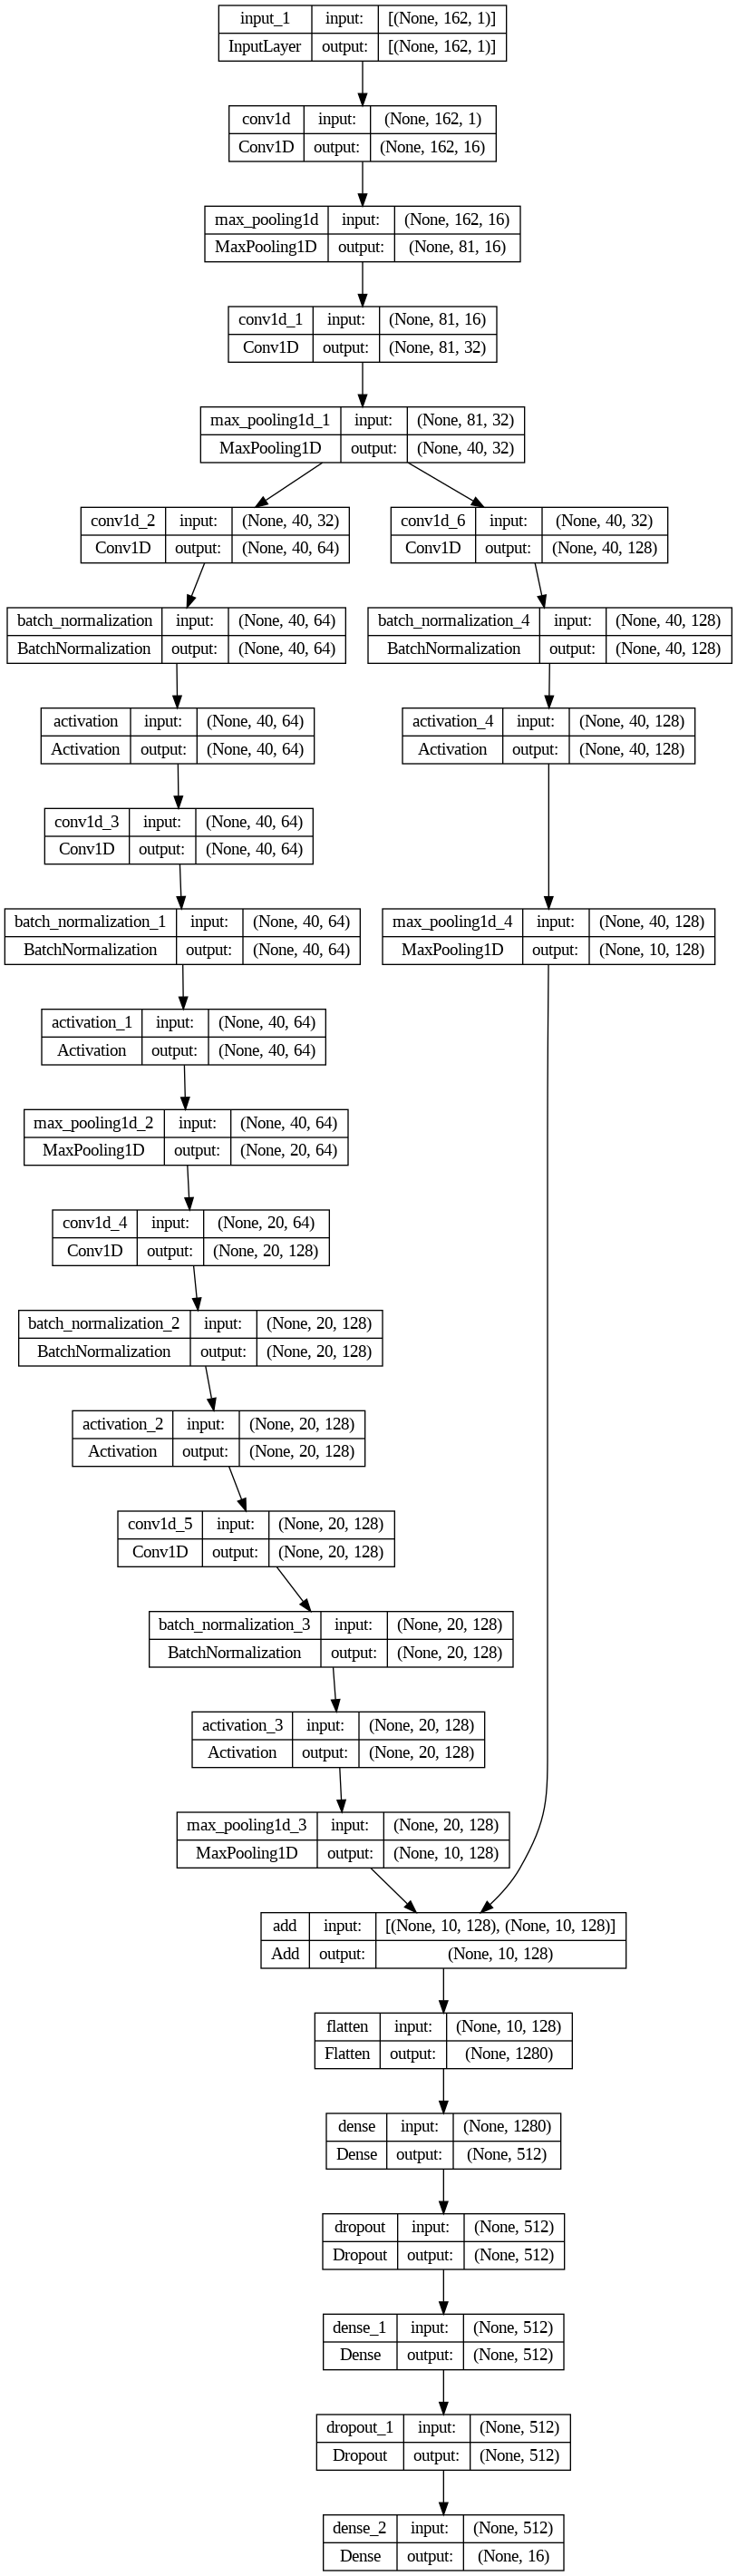

In [19]:
plot_model(model_branching_summed, show_shapes=True, show_layer_names=True, to_file=parent_folder+'model.png')

In [20]:
def f1_score(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [21]:
METRICS = [
  tf.keras.metrics.Accuracy(name='accuracy')
]

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2,min_lr=0.0001)
history=model_branching_summed.fit(x_train, y_train, batch_size=128, epochs=200, validation_split=0.2, callbacks=[rlrp])

Epoch 1/200
172/172 [==============================] - 22s 44ms/step - loss: 2.5452 - accuracy: 0.1481 - val_loss: 2.4164 - val_accuracy: 0.1853 - lr: 0.0100
Epoch 2/200
172/172 [==============================] - 5s 26ms/step - loss: 2.3057 - accuracy: 0.1966 - val_loss: 2.3024 - val_accuracy: 0.2054 - lr: 0.0100
Epoch 3/200
172/172 [==============================] - 4s 25ms/step - loss: 2.2018 - accuracy: 0.2296 - val_loss: 2.1139 - val_accuracy: 0.2452 - lr: 0.0100
Epoch 4/200
172/172 [==============================] - 4s 24ms/step - loss: 2.0884 - accuracy: 0.2679 - val_loss: 1.9027 - val_accuracy: 0.3406 - lr: 0.0100
Epoch 5/200
172/172 [==============================] - 5s 29ms/step - loss: 1.9143 - accuracy: 0.3256 - val_loss: 1.8489 - val_accuracy: 0.3483 - lr: 0.0100
Epoch 6/200
172/172 [==============================] - 2s 14ms/step - loss: 1.8221 - accuracy: 0.3556 - val_loss: 1.7547 - val_accuracy: 0.3744 - lr: 0.0100
Epoch 7/200
172/172 [==============================] - 2s

286/286 [==============================] - 1s 5ms/step - loss: 1.6616 - accuracy: 0.6710
Accuracy of our model on test data: 67.10482835769653 %


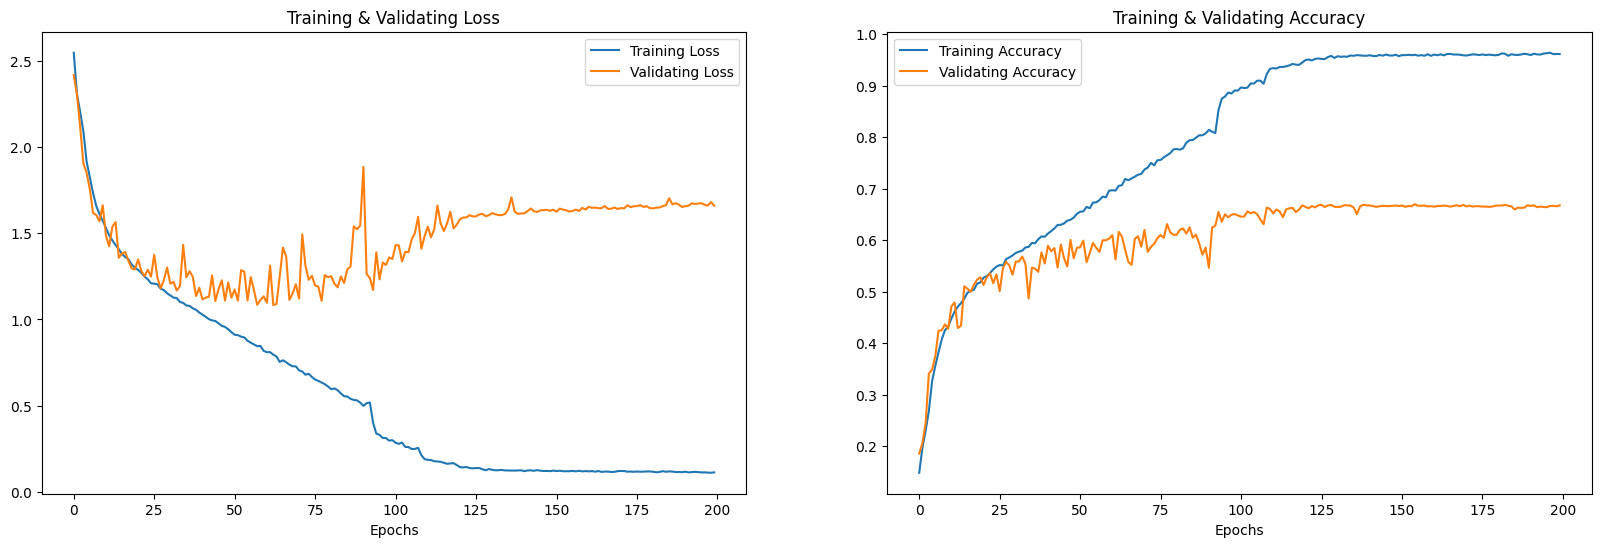

In [23]:
print("Accuracy of our model on test data:" , model_branching_summed.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(200)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [24]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize= (25,4))
  fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])
  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
  plt.show()

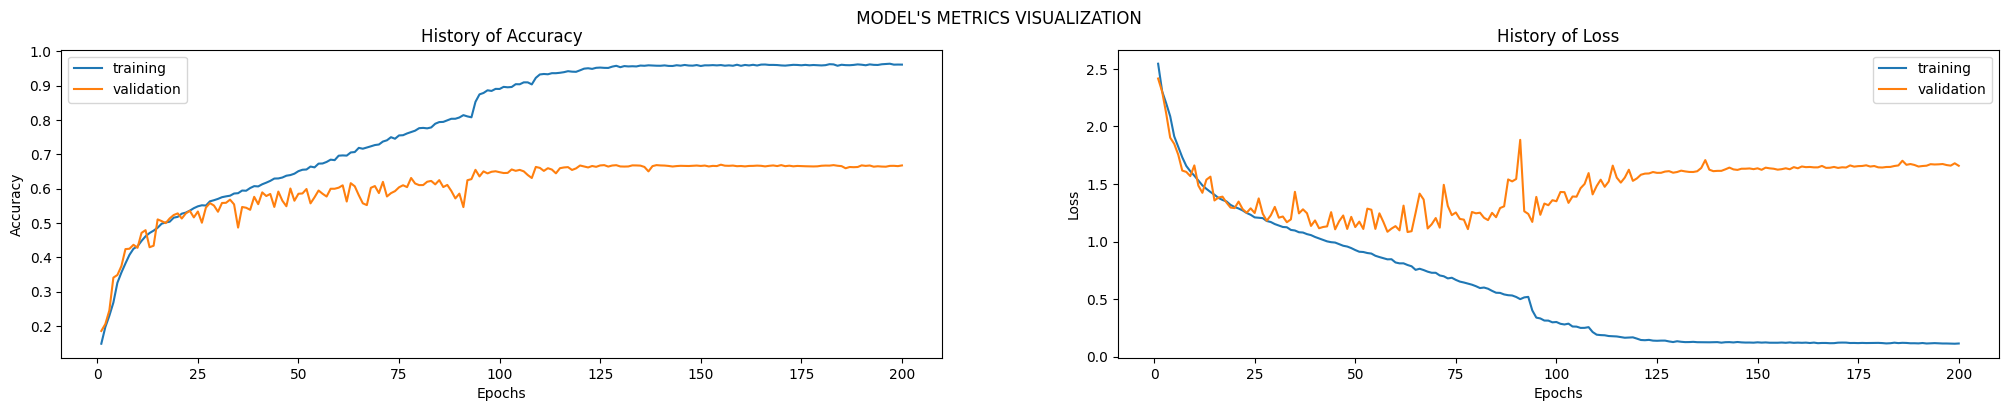

In [25]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
  history.history['loss'],history.history['val_loss']
)

In [26]:
pred_test = model_branching_summed.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

286/286 [==============================] - 2s 4ms/step


,Predicted Labels,Actual Labels
0,female_Neutral,female_Neutral
1,male_Fear,male_Fear
2,male_Anger,male_Anger
3,female_Sad,female_Sad
4,male_Sad,male_Fear
5,male_Neutral,male_Neutral
6,female_Happy,female_Happy
7,female_Anger,female_Anger
8,female_Fear,female_Fear
9,female_Sad,female_Sad


<ipython-input-27-262348620436>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


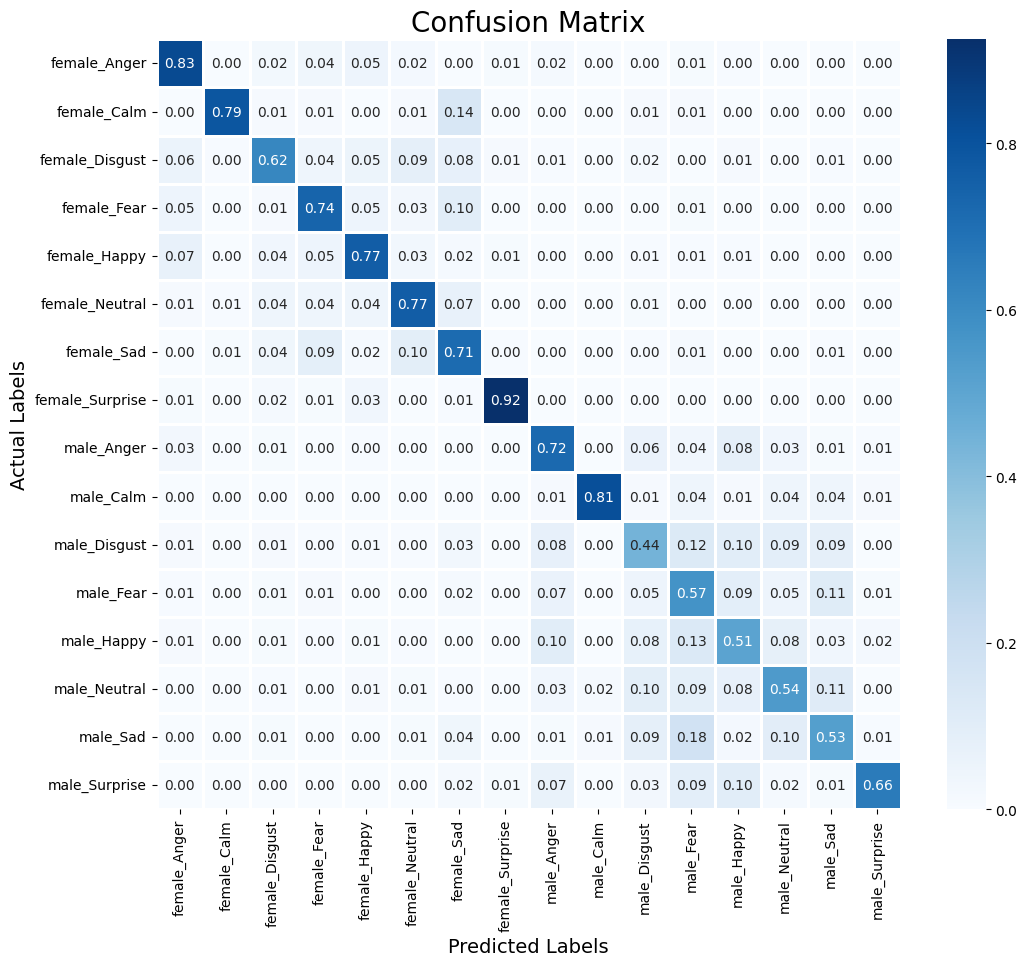

                 precision    recall  f1-score   support

   female_Anger       0.77      0.83      0.80       801
    female_Calm       0.76      0.79      0.77        76
 female_Disgust       0.76      0.62      0.68       851
    female_Fear       0.73      0.74      0.73       837
   female_Happy       0.76      0.77      0.76       840
 female_Neutral       0.70      0.77      0.73       715
     female_Sad       0.67      0.71      0.69       820
female_Surprise       0.91      0.92      0.92       373
     male_Anger       0.68      0.72      0.70       612
      male_Calm       0.73      0.81      0.77        70
   male_Disgust       0.53      0.44      0.48       640
      male_Fear       0.45      0.57      0.50       569
     male_Happy       0.55      0.51      0.53       638
   male_Neutral       0.55      0.54      0.55       533
       male_Sad       0.60      0.53      0.56       636
  male_Surprise       0.70      0.66      0.68       118

       accuracy              

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))